# Two-View Estimator

> Ayush Baid, Frank Dellaert

A notebook to investigate the TwoViewEstimator performance, using the Reichstag dataset.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import gtsam
from gtsam import Pose3, PinholeCameraCal3Bundler

from gtsfm.loader.yfcc_imb_loader import YfccImbLoader
from gtsfm.frontend.detector_descriptor.sift import SIFTDetectorDescriptor
from gtsfm.frontend.matcher.twoway_matcher import TwoWayMatcher
from gtsfm.utils import viz
from gtsfm.frontend.verifier.ransac import Ransac
from gtsfm.two_view_estimator import TwoViewEstimator

In [2]:
cwd = Path.cwd()
folder_path = cwd = Path.cwd().parent / "tests"/ "data" / "imb_reichstag"

In [3]:
# Load Images
indices = [2, 5]
loader = YfccImbLoader(str(folder_path))
images = [loader.get_image(i) for i in indices]

In [4]:
# Detect features
detector_descriptor = SIFTDetectorDescriptor()
features = [detector_descriptor.detect_and_describe(image) for image in images]
for i,(f,d) in enumerate(features):
    print(f"image {i+1}: {d.shape[0]} features")

image 1: 4039 features
image 2: 4470 features


In [5]:
# Do matching
matcher = TwoWayMatcher(ratio_test_threshold=0.8)
keypoints_i1, descriptors_i1 = features[0]
keypoints_i2, descriptors_i2 = features[1]
image_shape_i1 = images[0].value_array.shape
image_shape_i2 = images[1].value_array.shape
match_indices = matcher.match(
    keypoints_i1, keypoints_i2, descriptors_i1, descriptors_i2, image_shape_i1, image_shape_i2
)
print(f"{match_indices.shape[0]} matched.")

177 matched.


In [6]:
# Get intrinsics
camera_intrinsics_i1, camera_intrinsics_i2 = [loader.get_camera_intrinsics_full_res(i) for i in indices]
print(camera_intrinsics_i1)

.K[1108.62659; 0; 0; 515; 342.5];



In [7]:
# Do verification
verifier = Ransac(use_intrinsics_in_verification=False,
                  estimation_threshold_px=2)
i2Ri1, i2Ui1, v_corr_idxs, inlier_ratio_est_model = verifier.verify(
    keypoints_i1, keypoints_i2, match_indices, camera_intrinsics_i1, camera_intrinsics_i2)
print(f"ypr={np.degrees(i2Ri1.xyz())}\nU={i2Ui1.point3().T}\nverified:{v_corr_idxs.shape}\n{inlier_ratio_est_model=}")

[2022-05-07 14:04:09,186 WARNING verification.py line 90 95629] Recovered R, t cannot create the input Essential Matrix
ypr=[  2.59618287 -20.14430129   0.48493447]
U=[0.56683547 0.10055135 0.81767168]
verified:(125, 2)
inlier_ratio_est_model=0.7062146892655368


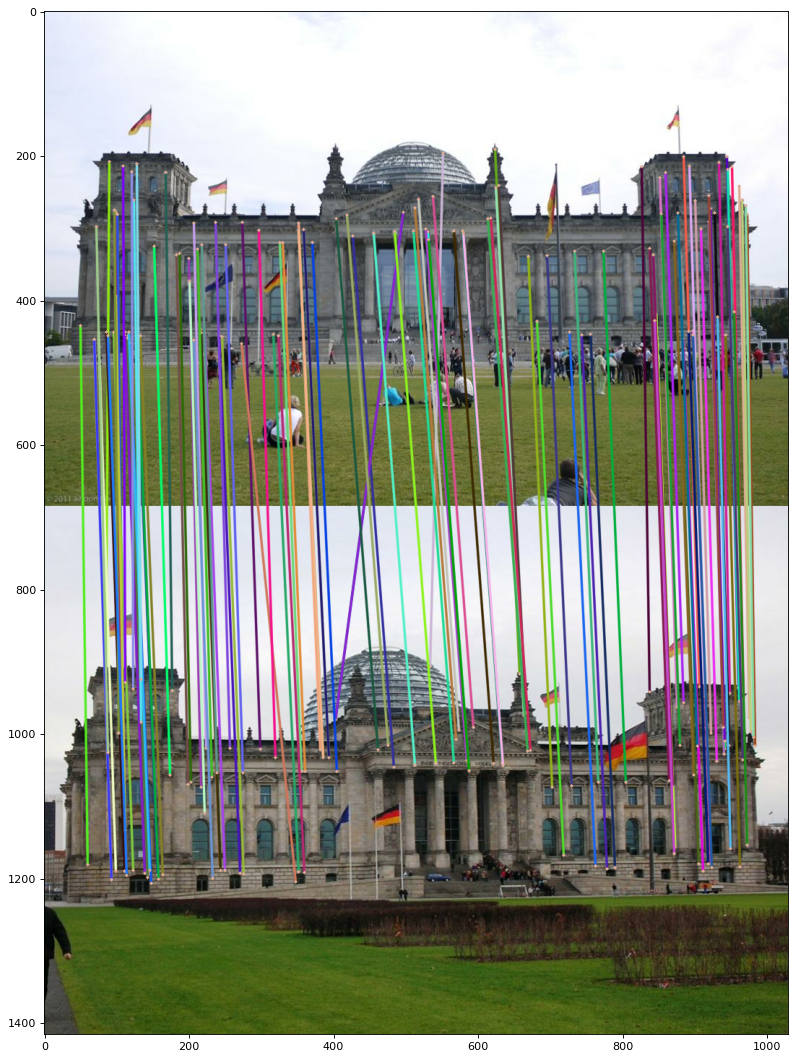

In [8]:
correspondence_image = viz.plot_twoview_correspondences(
    *images, keypoints_i1, keypoints_i2, v_corr_idxs, max_corrs=None)
fig = plt.figure(figsize=(12, 18), dpi=80)
fig.gca().imshow(correspondence_image.value_array)
plt.show()

In [9]:
# Create estimator
two_view_estimator = TwoViewEstimator(
    matcher=None, verifier=None, inlier_support_processor=None,
    bundle_adjust_2view=True, eval_threshold_px=4
)

In [10]:
# Sanity-check triangulation
i2Ti1_initial = Pose3(i2Ri1, i2Ui1.point3())
camera_i1 = PinholeCameraCal3Bundler(Pose3(), camera_intrinsics_i1)
camera_i2 = PinholeCameraCal3Bundler(
    i2Ti1_initial.inverse(), camera_intrinsics_i2)
tracks_3d, _ = two_view_estimator.triangulate_two_view_correspondences(
    camera_i1, camera_i2, keypoints_i1, keypoints_i2, v_corr_idxs)
points = np.array([t.point3() for t in tracks_3d]).T
print(points.shape)
fig = px.scatter_3d(x=points[0], y=points[2], z=-points[1])
fig.update_layout(scene=dict(aspectmode='data'))
fig.update_traces(marker_size=3)


(3, 125)


In [11]:
i2Ri1_optimized, i2Ui1_optimized, corr_idxs = two_view_estimator.bundle_adjust(
    keypoints_i1, keypoints_i2, v_corr_idxs, camera_intrinsics_i1, camera_intrinsics_i2, i2Ri1, i2Ui1)
print(f"ypr={np.degrees(i2Ri1_optimized.xyz())}\nU={i2Ui1_optimized.point3().T}\nverified:{corr_idxs.shape}")

[2022-05-07 14:04:10,143 DEBUG two_view_estimator.py line 174 95629] Performed DA in 0.003258 seconds.
[2022-05-07 14:04:10,144 DEBUG two_view_estimator.py line 175 95629] Triangulation succeeded on 125 correspondences.
[2022-05-07 14:04:10,145 INFO bundle_adjustment.py line 193 95629] Input: 125 tracks on 2 cameras

[2022-05-07 14:04:11,104 INFO bundle_adjustment.py line 211 95629] initial error: 570.81
[2022-05-07 14:04:11,104 INFO bundle_adjustment.py line 212 95629] final error: 7.64
[2022-05-07 14:04:11,127 INFO bundle_adjustment.py line 218 95629] [Result] Number of tracks before filtering: 125
[2022-05-07 14:04:11,132 INFO bundle_adjustment.py line 227 95629] [Result] Number of tracks after filtering: 118
[2022-05-07 14:04:11,133 DEBUG two_view_estimator.py line 191 95629] Performed 2-view BA in 0.988571 seconds.
ypr=[  1.27586227 -16.00271097   0.54841626]
U=[0.41065338 0.06390306 0.90954945]
verified:(118, 2)


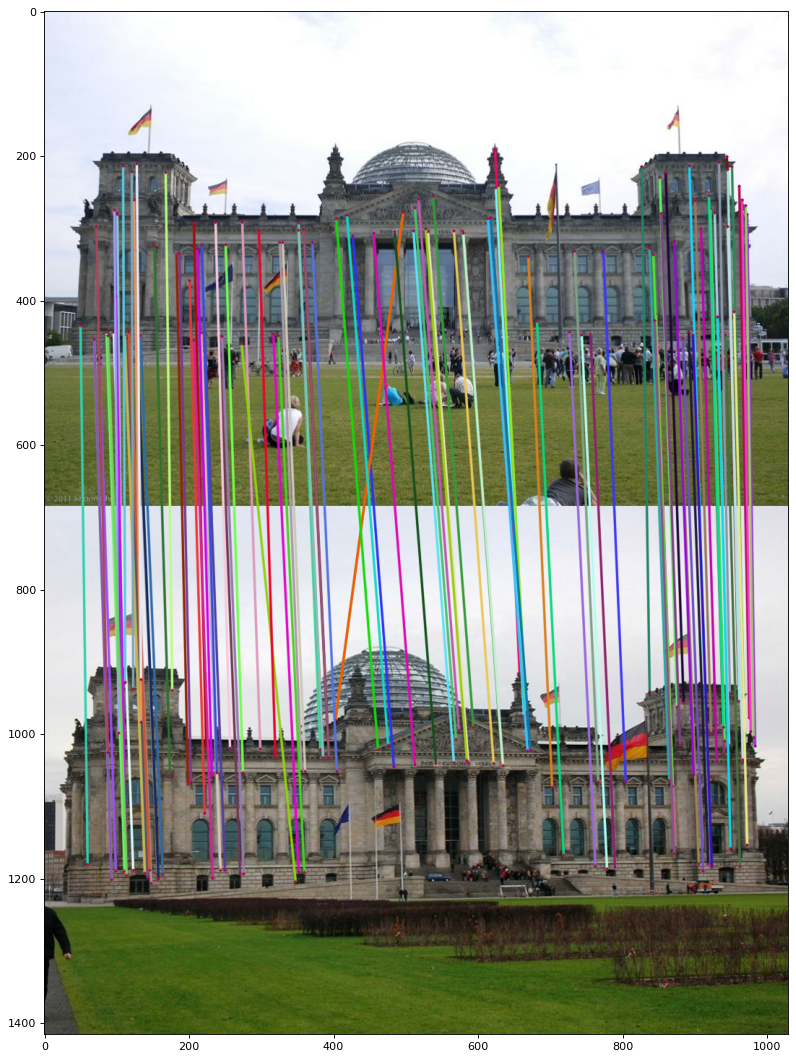

In [12]:
correspondence_image = viz.plot_twoview_correspondences(*images, keypoints_i1, keypoints_i2, corr_idxs, max_corrs=None)
fig = plt.figure(figsize=(12, 18), dpi=80)
fig.gca().imshow(correspondence_image.value_array)
plt.show()

In [13]:
# Sanity-check triangulation after BA
i2Ti1_optimized = Pose3(i2Ri1_optimized, i2Ui1_optimized.point3())
camera_i1 = PinholeCameraCal3Bundler(Pose3(), camera_intrinsics_i1)
camera_i2 = PinholeCameraCal3Bundler(
    i2Ti1_optimized.inverse(), camera_intrinsics_i2)
ba_tracks_3d, _= two_view_estimator.triangulate_two_view_correspondences(
    camera_i1, camera_i2, keypoints_i1, keypoints_i2, corr_idxs)
ba_points = np.array([t.point3() for t in ba_tracks_3d]).T
print(ba_points.shape)
fig = px.scatter_3d(x=ba_points[0], y=ba_points[2], z=-ba_points[1])
fig.update_layout(scene=dict(aspectmode='data'))
fig.update_traces(marker_size = 3)

(3, 118)
